In [1]:
# import urllib
# import zipfile
# import os

# def download_data():
#     if not os.path.exists("tiny-imagenet-200"):
#         urllib.request.urlretrieve(
#             "http://cs231n.stanford.edu/tiny-imagenet-200.zip", "tiny-imagenet-200.zip"
#         )
#         file = zipfile.ZipFile("tiny-imagenet-200.zip", "r")
#         file.extractall()


# download_data()


In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import sklearn
import torch
import cv2
import os

# HELP functions

In [4]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

In [5]:
with open(
    "C:\gr\TempFolder\\NeuralNetworks\datasets\\tiny-imagenet-200\\words.txt"
) as f:
    class_map = dict(map(lambda x: x.replace("\n", "").split("\t"), f.readlines()))


In [6]:
def draw_dataset(ds, grid_shape=3, figsize=(10, 10)):
    fig, ax = plt.subplots(grid_shape, grid_shape, figsize=figsize)
    indx = torch.randint(len(ds), size=(grid_shape, grid_shape))
    for i in range(grid_shape):
        for j in range(grid_shape):
            img, label = ds[indx[i, j]]
            img = img.moveaxis(0, 2)
            ax[i][j].imshow(img)
            label = class_map[ds.classes[label]]
            ax[i][j].set_title((label if len(label) < 20 else (label[:15] + "...")))


In [7]:
class ImageDataset(Dataset):
    def __init__(
        self,
        root,
        image_name_to_classes,
        class_to_idx,
        classes,
        transform=None,
        target_transform=None,
    ):
        self.root = root
        self.paths = list(map(lambda x: os.path.join(self.root, x), os.listdir(root)))
        self.image_name_to_classes = image_name_to_classes
        self.class_to_idx = class_to_idx
        self.classes = classes
        self.transform = transform
        self.target_transform = target_transform

        self.data = [
            (
                cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR),
                self.class_to_idx[self.image_name_to_classes[
                    os.path.basename(path)
                ]]
            )
            for path in tqdm(self.paths, desc="LOAD images")]
        self.images = np.array(list(map(lambda x: x[0], self.data)))
        self.labels = np.array(list(map(lambda x: x[1], self.data)))
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [8]:
train_ds = ImageFolder(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\tiny-imagenet-200\\train",
    transform=v2.Compose(
        [
            v2.ToTensor(),
            v2.RandomHorizontalFlip(),
            # v2.ColorJitter(
            #     brightness=0.15,
            #     saturation=0.15,
            #     hue=0.05,
            # ),
            v2.RandomRotation(10),
            v2.RandomResizedCrop(64, (0.6, 0.9)),
            # v2.ElasticTransform(50),
        ]
    ),
)

with open(
    "C:\gr\TempFolder\\NeuralNetworks\datasets\\tiny-imagenet-200\\val\\val_annotations.txt"
) as f:
    val_annot = dict(map(lambda x: x.split("\t")[:2], f.readlines()))

val_ds = ImageDataset(
    "C:\\gr\\TempFolder\\NeuralNetworks\\datasets\\tiny-imagenet-200\\val\\images",
    val_annot,
    train_ds.class_to_idx,
    train_ds.classes,
    transform=v2.Compose(
        [
            v2.ToTensor(),
        ]
    ),
)

c:\gr\TempFolder\.conda\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


LOAD images:   0%|          | 0/10000 [00:00<?, ?it/s]

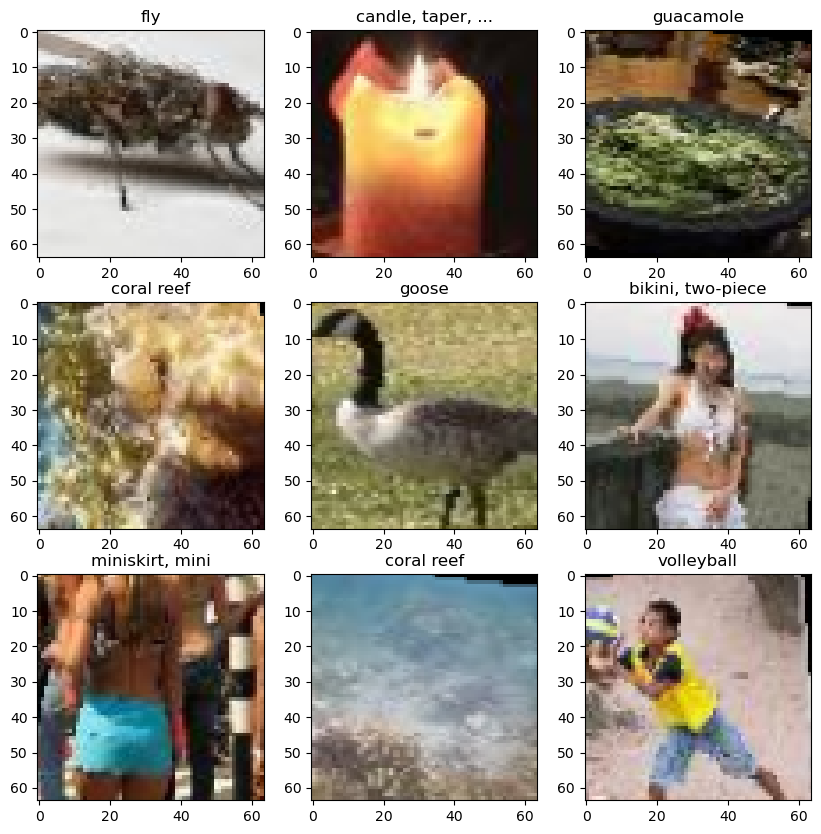

In [9]:
draw_dataset(train_ds)

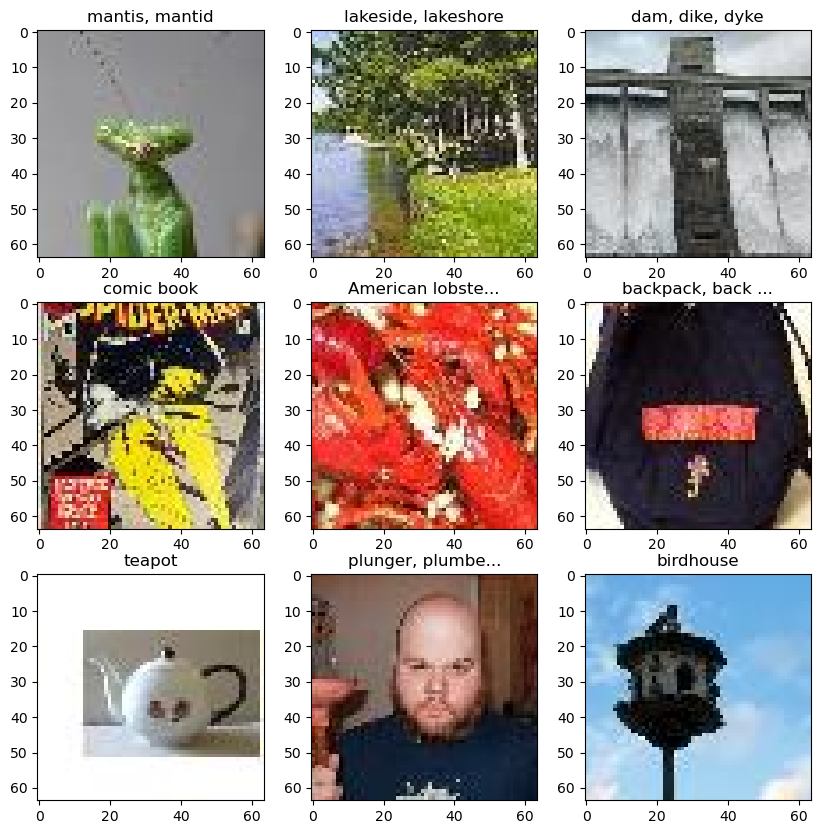

In [10]:
draw_dataset(val_ds)

In [11]:
from torch.utils.data import DataLoader

In [12]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)


In [13]:
# class ResBlock(torch.nn.Module):
#     def __init__(
#         self, input_chanels=32, inner_size=32, out_size=32, inner_count=2, device="cpu"
#     ):
#         super(ResBlock, self).__init__()

#         self.conv = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(input_chanels),
#             torch.nn.Conv2d(input_chanels, inner_size, 3, padding=1),
#             torch.nn.LeakyReLU(),
#             torch.nn.BatchNorm2d(inner_size),
#             torch.nn.Dropout(0.6),
#         )

#         for i in range(inner_count):
#             self.conv.add_module(
#                 f"inner_{i}",
#                 torch.nn.Sequential(
#                     torch.nn.Conv2d(inner_size, inner_size, 3, padding=1),
#                     torch.nn.LeakyReLU(),
#                     torch.nn.BatchNorm2d(inner_size),
#                     torch.nn.Dropout(0.7),
#                 ),
#             )
#         self.conv.add_module(
#             "output",
#             torch.nn.Sequential(
#                 torch.nn.Conv2d(inner_size, out_size, 3, padding=1),
#                 torch.nn.LeakyReLU(),
#             ),
#         )

#         self.residual = torch.nn.Sequential()

#         if input_chanels != out_size:
#             self.residual.add_module(
#                 "change res shape", torch.nn.Conv2d(input_chanels, out_size, 1)
#             )

#     def forward(self, x):
#         return self.residual(x) + self.conv(x)


# class ConvModel(torch.nn.Module):
#     def __init__(self, device="cpu"):
#         super(ConvModel, self).__init__()

#         self.res_part = torch.nn.Sequential(
#             ResBlock(3, 16, 16, 2),
#             torch.nn.MaxPool2d(2),
#             ResBlock(16, 32, 16, 2),
#             torch.nn.MaxPool2d(2),
#             ResBlock(16, 64, 16, 2),
#             torch.nn.MaxPool2d(2),
#             ResBlock(16, 64, 32, 2),
#             torch.nn.MaxPool2d(3),
#         )

#         self.fc = torch.nn.Sequential(
#             torch.nn.Flatten(),
#             torch.nn.Linear(128, 200),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(200, 200),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(200, 200),
#         )

#     def forward(self, x):
#         x = self.res_part(x)
#         return self.fc(x)


# model = ConvModel(device="cuda").to(device="cuda")


# model(next(iter(train_dl))[0].to(device="cuda")).shape

# print(get_n_params(model))
# logdir = os.path.join("logs/tiny_imgnet/resnet", str(get_n_params(model)))
# writer = SummaryWriter(log_dir=logdir)
# writer.add_graph(model, next(iter(train_dl))[0].to(device="cuda"))

In [14]:
class ConvModel(torch.nn.Module):
    def __init__(self, device="cpu"):
        super(ConvModel, self).__init__()

        self.conv: torch.nn.Sequential = torch.nn.Sequential(
            #
            torch.nn.Conv2d(3, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.LeakyReLU(),
            #
            torch.nn.Conv2d(8, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            #
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            #
            # torch.nn.MaxPool2d(2),
            #
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            #
            torch.nn.Conv2d(64, 128, 3),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(),
            # torch.nn.Conv2d(128, 128, 3, padding=1),
            # torch.nn.BatchNorm2d(128),
            # torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128, 256, 3),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(),
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 200),
            torch.nn.BatchNorm1d(200),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(200, 200),
            torch.nn.BatchNorm1d(200),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(200, 200),
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


model = ConvModel(device="cuda").to(device="cuda")

model(next(iter(train_dl))[0].to(device="cuda")).shape

logdir = os.path.join("logs/tiny_imgnet/large_conv", str(get_n_params(model)))
writer = SummaryWriter(log_dir=logdir)
writer.add_graph(model, next(iter(train_dl))[0].to(device="cuda"))
get_n_params(model)


594504

In [15]:
# from torchvision.models import resnet18, ResNet18_Weights

# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# for param in model.parameters():
#     param.requires_grad = False

# model.fc = torch.nn.Sequential(
#     torch.nn.BatchNorm1d(512),
#     torch.nn.Linear(512, 256),
#     torch.nn.LeakyReLU(),
#     torch.nn.BatchNorm1d(256),
#     torch.nn.Linear(256, 256),
#     torch.nn.LeakyReLU(),
#     torch.nn.BatchNorm1d(256),
#     torch.nn.Linear(256, 200),
# )
# model.layer4.requires_grad_(True)

# model = model.to(device="cuda")
# model(next(iter(train_dl))[0].to(device="cuda")).shape

# logdir = os.path.join("logs/tiny_imgnet/resnet18", str(get_n_params(model)))
# writer = SummaryWriter(log_dir=logdir)
# writer.add_graph(model, next(iter(train_dl))[0].to(device="cuda"))
# get_n_params(model)

In [16]:
optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()

In [17]:
val_data = (
    torch.tensor(val_ds.images, requires_grad=False)
    .moveaxis(3, 1)
    .to(device="cuda")
    / 255
)

val_labels = (
    torch.tensor(val_ds.labels, requires_grad=False)
    .to(device="cuda")
    .to(dtype=torch.int64)
)

In [18]:
with tqdm(range(30)) as epoch_iter:
    for ep in epoch_iter:
        model.train(True)
        running_acc = 0
        running_count = 0
        running_loss = 0
        with tqdm(train_dl) as train_iter:
            for i, (data, target) in enumerate(train_iter):
                
                data = data.to(device="cuda")
                target = target.to(device="cuda")

                optimizer.zero_grad()
                pred = model(data)

                loss = loss_func(pred, target)
                loss.backward()
                running_loss += loss.detach()
                running_acc += (pred.detach().argmax(dim=-1) == target).sum()
                running_count += len(target)

                optimizer.step()

                if i % 60 == 59:
                    writer.add_scalars(
                        "accuracy",
                        {
                            "train": running_acc / running_count,
                        },
                        len(train_dl) * ep + i,
                    )
                    writer.add_scalars(
                        "loss",
                        {
                            "train": running_loss / i,
                        },
                        len(train_dl) * ep + i,
                    )
                    train_iter.set_description(str(running_acc / running_count))
                    running_count = 0
                    running_acc = 0
                    running_loss = 0
                torch.cuda.empty_cache()
                del data
                del target
                del pred
        with torch.no_grad():
            model.eval()
            pred = model(val_data)
            # loss = loss_func(pred, labels)
            acc = (pred.argmax(dim=-1) == val_labels).sum() / len(val_labels)
            writer.add_scalars(
                "accuracy",
                {
                    "valid": acc,
                },
                len(train_dl) * (ep + 1),
            )
            epoch_iter.set_description(str(acc))

            fig, ax = plt.subplots(figsize=(40, 40))
            sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
                val_labels.detach().cpu().numpy(),
                pred.detach().cpu().argmax(dim=-1).numpy(),
                display_labels={
                    train_ds.class_to_idx[key]: value
                    for key, value in class_map.items()
                    if key in train_ds.class_to_idx
                },
                ax=ax,
                colorbar=False,
            )

            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba(), dtype=np.int32)
            plt.close()
            writer.add_image(
                tag="Confusion matrix valid",
                img_tensor=np.moveaxis(img, -1, 0) / 255,
                global_step=len(train_dl) * ep,
            )

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 